In [1]:
import pandas as pd
import numpy as np

In [3]:
pip install optbinning

Note: you may need to restart the kernel to use updated packages.Collecting optbinning
   ---------------------------------------- 0.0/213.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/213.9 kB ? eta -:--:--
   ----- --------------------------------- 30.7/213.9 kB 330.3 kB/s eta 0:00:01
   -------------- ------------------------ 81.9/213.9 kB 657.6 kB/s eta 0:00:01
   -------------- ------------------------ 81.9/213.9 kB 657.6 kB/s eta 0:00:01
   ---------------- ---------------------- 92.2/213.9 kB 438.1 kB/s eta 0:00:01
   ---------------- ---------------------- 92.2/213.9 kB 438.1 kB/s eta 0:00:01
   --------------------- ---------------- 122.9/213.9 kB 400.9 kB/s eta 0:00:01
   --------------------- ---------------- 122.9/213.9 kB 400.9 kB/s eta 0:00:01
   ------------------------- ------------ 143.4/213.9 kB 327.9 kB/s eta 0:00:01
   ---------------------------------- --- 194.6/213.9 kB 421.8 kB/s eta 0:00:01
   ---------------------------------- --- 194.6/21

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.1 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.


   -------- ------------------------------ 29.5/142.5 MB 393.7 kB/s eta 0:04:47
   -------- ------------------------------ 29.5/142.5 MB 393.7 kB/s eta 0:04:47
   -------- ------------------------------ 29.5/142.5 MB 393.7 kB/s eta 0:04:47
   -------- ------------------------------ 29.5/142.5 MB 393.7 kB/s eta 0:04:47
   -------- ------------------------------ 29.6/142.5 MB 391.6 kB/s eta 0:04:49
   -------- ------------------------------ 29.6/142.5 MB 391.6 kB/s eta 0:04:49
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ------------------------------ 29.6/142.5 MB 390.4 kB/s eta 0:04:50
   -------- ----------------------------

In [4]:
df = pd.read_csv("E:\\J P Morgan Quantitative Research\\Task4.csv")
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [7]:
import pandas as pd
from optbinning import OptimalBinning

# Assume df has columns: ['fico_score', 'default']
X = df['fico_score'].values
y = df['default'].values

# Initialize the binning object
optb = OptimalBinning(name="fico", dtype="numerical", max_n_bins=5, solver="cp")

# Fit the algorithm
optb.fit(X, y)

# Get bucketed values as integer codes
df['fico_bucket'] = optb.transform(X, metric="indices").astype(int)

# Retrieve the actual bucket boundaries
boundaries = optb.binning_table.build()['Bin'].tolist()
print("Bucket boundaries:", boundaries)


Bucket boundaries: ['(-inf, 550.50)', '[550.50, 610.50)', '[610.50, 649.50)', '[649.50, 719.50)', '[719.50, inf)', 'Special', 'Missing', '']


In [9]:
# Group by fico_bucket and calculate count, number of defaults, and PD
bucket_summary = (
    df.groupby('fico_bucket')['default']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'Total_Borrowers', 'sum': 'Defaults'})
)

# Add default rate (PD)
bucket_summary['PD (%)'] = (bucket_summary['Defaults'] / bucket_summary['Total_Borrowers']) * 100
bucket_summary['PD (%)'] = bucket_summary['PD (%)'].round(2)

# Optional: reset index if you want a flat table
bucket_summary = bucket_summary.reset_index()

print(bucket_summary)


   fico_bucket  Total_Borrowers  Defaults  PD (%)
0            0              758       411   54.22
1            1             2443       691   28.28
2            2             2533       416   16.42
3            3             3414       307    8.99
4            4              852        26    3.05


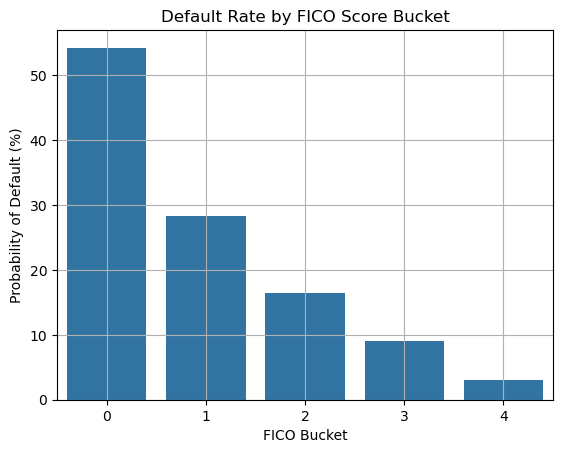

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='fico_bucket', y='PD (%)', data=bucket_summary)
plt.title("Default Rate by FICO Score Bucket")
plt.xlabel("FICO Bucket")
plt.ylabel("Probability of Default (%)")
plt.grid(True)
plt.show()

## 📊 Interpretation: Default Rate by Log-Likelihood Optimized FICO Buckets

The following results represent the outcome of discretizing FICO scores using **log-likelihood maximization** — a statistically principled method for risk segmentation:

| FICO Bucket | Total Borrowers | Defaults | PD (%) |
|-------------|------------------|----------|--------|
| 0 (Most Risky)     | 758               | 411      | 54.22% |
| 1                  | 2443              | 691      | 28.28% |
| 2                  | 2533              | 416      | 16.42% |
| 3                  | 3414              | 307      | 8.99%  |
| 4 (Least Risky)    | 852               | 26       | 3.05%  |

### 🔍 Key Takeaways:
- The **default probability (PD)** drops **monotonically** as we move from Bucket 0 to Bucket 4 — confirming effective segmentation by risk.
- **Bucket 0**, comprising the **riskiest borrowers**, shows an extremely high PD of **54.22%**.
- In contrast, **Bucket 4** shows a low PD of just **3.05%**, indicating **excellent credit performance**.
- These buckets were determined by maximizing the **log-likelihood** of defaults, ensuring that the segmentation best reflects the underlying distribution of credit risk.

### ✅ Conclusion:
The log-likelihood–based bucketing strategy delivers the **most statistically optimized risk separation**, making it highly suitable for classification models or credit risk scorecards that demand robust and informative categorical inputs.
